# Coloring Graphs by RSN

Goal: color each node with multiple (activated) networks.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import dyneusr as ds
import kmapper as km
import networkx as nx

In [3]:
import numpy as np
import pandas as pd
import scipy.stats

from sklearn.datasets.base import Bunch
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE

from umap.umap_ import UMAP
from hdbscan import HDBSCAN

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [5]:
from collections import Counter, OrderedDict
from functools import partial
from itertools import product

## Load sessions

In [6]:
from load_data import load_scrubbed

session, = load_scrubbed(n_sessions=1, merge=False)

INFO:load_data:load_scrubbed(**{'n_sessions': 1, 'merge': False})
INFO:load_data:Loading data...
INFO:root:  [+] session: 1, path: data/base/combined_data_scrubbed/sub014.txt


## Resting-State Network parcellation labels

In [7]:
def get_RSN_act(x, atlas, threshold=0.5, zscore=True):
    """ Compute mean activity for RSN at each TR.
    
    Inputs
    ------
        :x = np.ndarray (TR, ROI)
        
        :atlas = pd.DataFrame.networks = (ROI, RSN)
        
    """
    x_ = x.copy() 
    
    # z-score (?)
    if zscore is True:
        x_ = scipy.stats.zscore(x_, axis=0)

    # get average RSN activity for each network
    # TODO: this could be its own function
    rsn_rois = atlas.networks.groupby('network').indices.items()
    rsn_act = {rsn: x_[:, rois].mean(axis=1) for (rsn, rois) in rsn_rois}

    # save as DataFrame
    df_rsn_act = pd.DataFrame(rsn_act)
    
    # threshold (?)
    if threshold:
        df_rsn_act = df_rsn_act.ge(0.5).astype(int)
    
    return df_rsn_act

In [8]:
df_rsn_bin = get_RSN_act(session.X, session.atlas)
df_rsn_act = get_RSN_act(session.X, session.atlas, threshold=None)

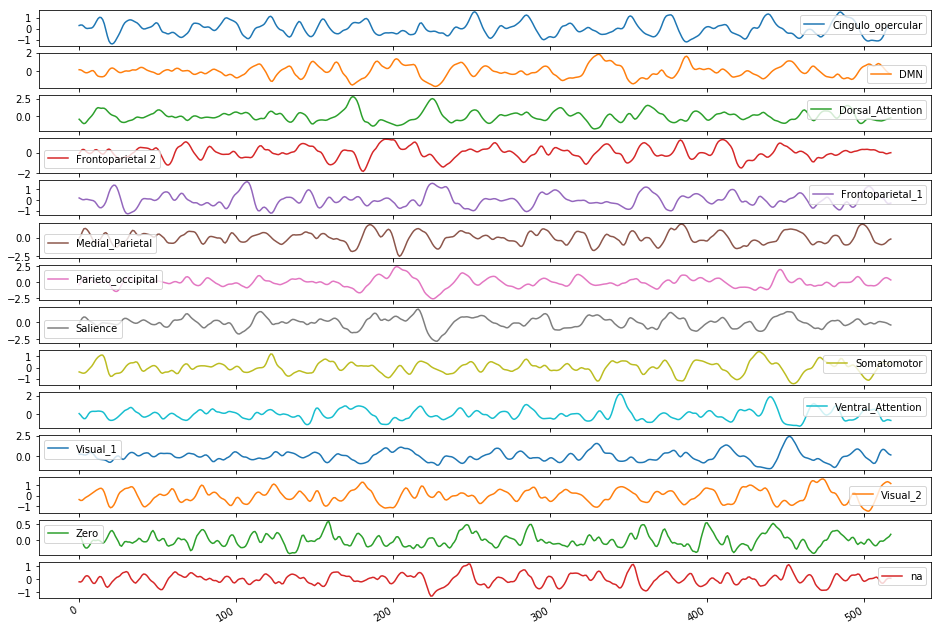

In [9]:
_ = df_rsn_act.plot(subplots=True,figsize=(16,12))

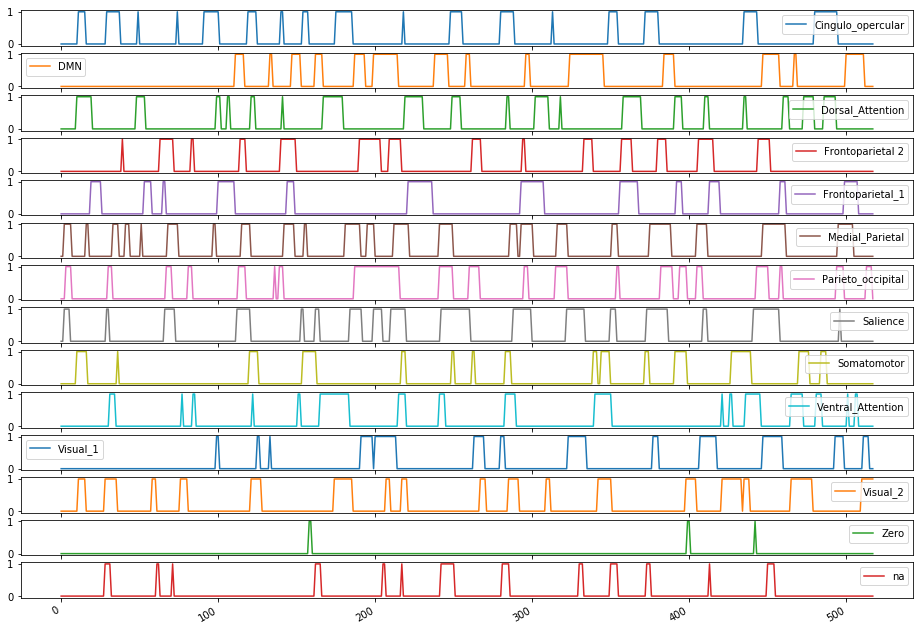

In [10]:
_ = df_rsn_bin.plot(subplots=True,figsize=(16,12))

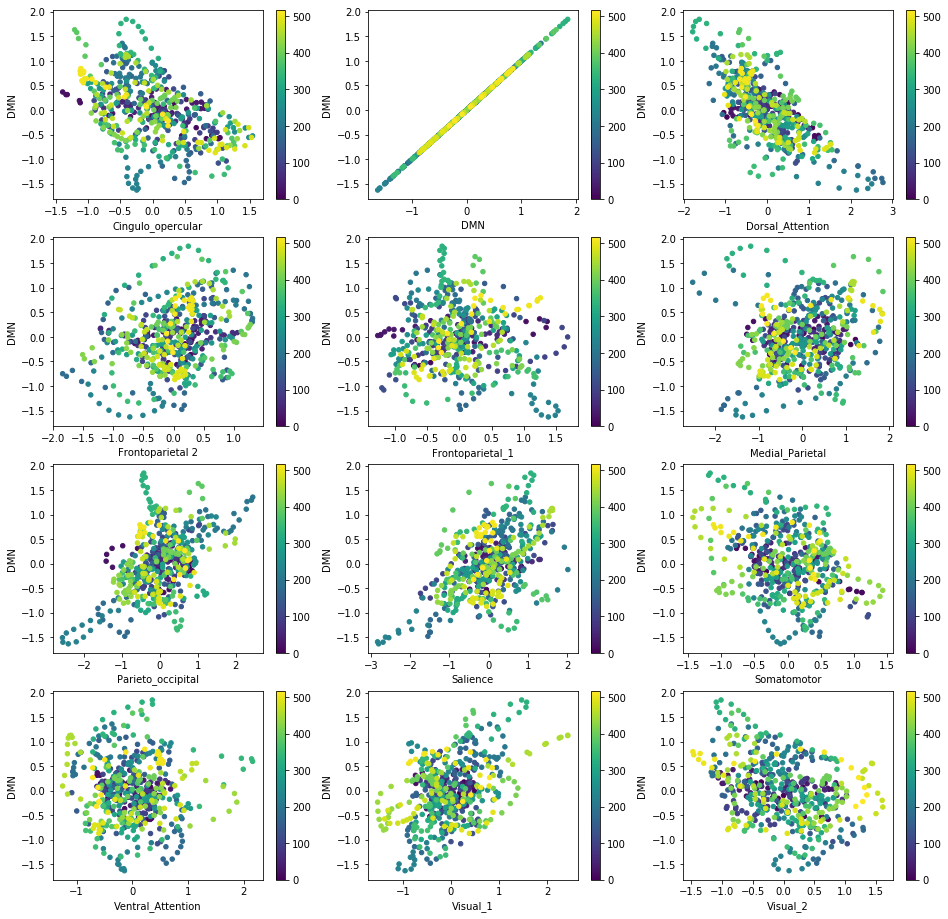

In [11]:
fig,axes = plt.subplots(4,3, figsize=(16,16))
axes = np.ravel(axes)

for i,c in enumerate(df_rsn_act.columns[:-2]):
    _ = df_rsn_act.plot.scatter(
        x=c, y='DMN', c=df_rsn_act.index, 
        cmap='viridis', 
        ax=axes[i],
        )

### Generate a Mapper graph

In [12]:
mapper = km.KeplerMapper(verbose=0)
lens = mapper.fit_transform(
    df_rsn_act.values[:, :2], projection=[0, 1]
    )

In [13]:
# map
mapper = km.KeplerMapper(verbose=1)
graph = mapper.map(
    lens, session.X, 
    clusterer=HDBSCAN(allow_single_cluster=True), 
    coverer=km.Cover(10, 0.67)
    )

KeplerMapper()
Mapping on data shaped (518, 630) using lens shaped (518, 2)

Creating 100 hypercubes.

Created 96 edges and 57 nodes in 0:00:00.170453.


### Multi-coloring

In [14]:
dG = ds.DyNeuGraph(G=graph, y=df_rsn_bin)

label,group,value,row_count
Cingulo_opercular,0,107,517
DMN,1,111,517
Dorsal_Attention,2,109,517
Frontoparietal 2,3,93,517
Frontoparietal_1,4,97,517
Medial_Parietal,5,143,517
Parieto_occipital,6,117,517
Salience,7,133,517
Somatomotor,8,78,517
Ventral_Attention,9,84,517


In [15]:
%%bash --bg

python3 -m http.server 8880

Starting job # 0 in a separate thread.


In [18]:
dG.visualize(path_html='results/Session14_RSN.html', path_assets='results', show=True, PORT=8880)

[Force Graph] http://localhost:8880/results/Session14_RSN.html


DyNeuGraph()

<Figure size 432x288 with 0 Axes>